<a href="https://colab.research.google.com/github/manjunathsirur1994/Time_series_forecasting/blob/main/TS_SARIMA_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import yfinance as yf

In [73]:
ticker = 'LLOYDSME.NS'

df = yf.download(ticker, start='2000-01-01', multi_level_index=False)
df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2023-07-17 00:00:00+00:00,562.558289,563.299988,582.700012,550.500000,554.000000,417232
2023-07-18 00:00:00+00:00,543.583313,544.299988,573.900024,531.000000,573.900024,284708
2023-07-19 00:00:00+00:00,565.504395,566.250000,572.000000,541.250000,564.700012,208966
2023-07-20 00:00:00+00:00,563.307312,564.049988,572.700012,557.000000,572.700012,108284
2023-07-21 00:00:00+00:00,557.964355,558.700012,564.500000,550.049988,564.500000,189224


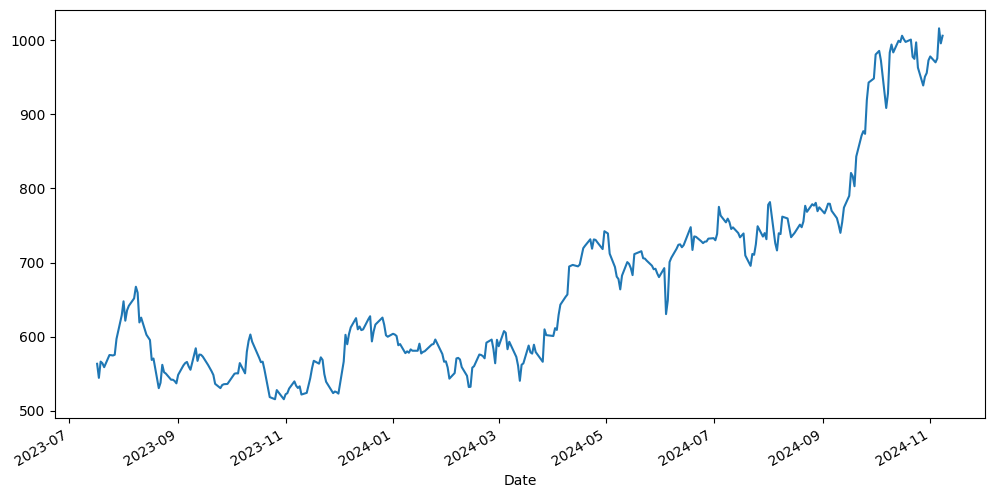

In [74]:
df['Close'].plot(figsize=(12,6));

In [75]:
df.shape

(325, 6)

In [76]:
df = df.resample("B").last()
df.shape

(345, 6)

In [77]:
df.fillna(method='ffill', inplace=True)
df.shape

<ipython-input-77-1df6602c9f4d>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


(345, 6)

In [78]:
df.isna().sum()

,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [79]:
ts = df[['Close']]
ts.head()

,Close
Date,
2023-07-17 00:00:00+00:00,563.299988
2023-07-18 00:00:00+00:00,544.299988
2023-07-19 00:00:00+00:00,566.250000
2023-07-20 00:00:00+00:00,564.049988
2023-07-21 00:00:00+00:00,558.700012


In [80]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values:{result[4]}')

ADF Statistic: 0.5508485765748905
p-value: 0.9863393452287966
Critical Values:{'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}


In [81]:
ts['close_diff'] = ts['Close'].diff()
ts.dropna(inplace=True)
ts.shape

<ipython-input-81-d9944f5a6e05>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['close_diff'] = ts['Close'].diff()
<ipython-input-81-d9944f5a6e05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts.dropna(inplace=True)


(344, 2)

In [82]:
results = adfuller(ts['close_diff'])
print(f'ADF Statistic: {results[0]}')
print(f'p-value: {results[1]}')
print(f'Critical Values:{results[4]}')

ADF Statistic: -14.482804828434062
p-value: 6.331769540388349e-27
Critical Values:{'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}


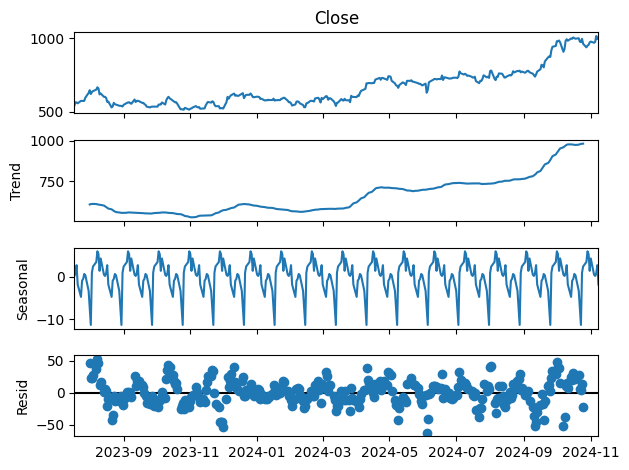

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts['Close'], model='additive', period=20)
result.plot();

<ipython-input-84-318f7c0b0101>:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/np.abs(fft_freq), np.abs(fft_vals))


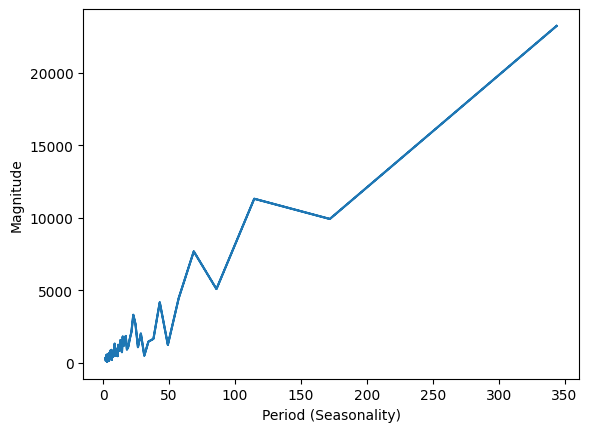

In [84]:
import numpy as np
import matplotlib.pyplot as plt

fft_vals = np.fft.fft(ts['Close'])
fft_freq = np.fft.fftfreq(len(fft_vals))

# Plot the magnitudes of the FFT to find the dominant frequency
plt.plot(1/np.abs(fft_freq), np.abs(fft_vals))
plt.xlabel('Period (Seasonality)')
plt.ylabel('Magnitude')
plt.show()

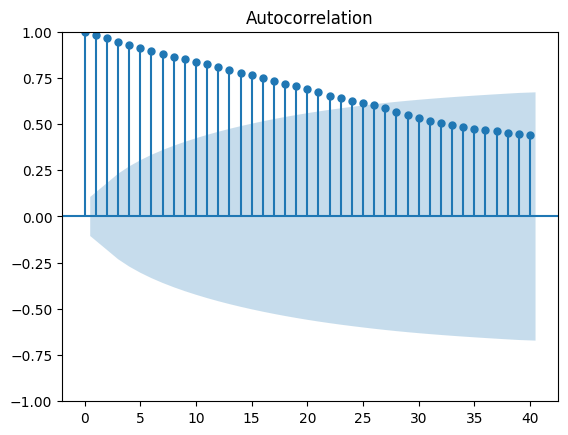

In [85]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(ts['Close'], lags=40)  # Adjust lags to view multiple cycles
plt.show()

In [86]:
ts.shape

(344, 2)

In [87]:
df_train = ts.head(300)
df_test = ts.tail(45)

In [88]:
from statsmodels.tsa.statespace import sarimax
import itertools

model_params = {}
P=D=Q = range(0,2)
S = [20]
PDQ = list(itertools.product(P,D,Q,S))

for params in PDQ:
  try:
    model = sarimax.SARIMAX(df_train['Close'], order=(0,1,3), seasonal_order=(params))
    model_fit = model.fit()
    model_params[params] = model_fit.aic
  except:
    print("error")

In [89]:
min(model_params, key=model_params.get)

(0, 1, 1, 20)

In [90]:
model = sarimax.SARIMAX(df_train['Close'], order=(0,1,3), seasonal_order=(0,1,1,20)) # to find pdq value build arima model first then take optimal pdq value.
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  300
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 20)   Log Likelihood               -1168.849
Date:                              Mon, 11 Nov 2024   AIC                           2347.698
Time:                                      08:03:00   BIC                           2365.854
Sample:                                  07-18-2023   HQIC                          2354.981
                                       - 09-09-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0406      0.060     -0.674      0.500      -0.158       0.077
ma.L2         -0.0576      0.045     -1.275      0.202      -0.146       0.031
ma.L3          0.0146      0.075      0.195      0.846      -0.132       0.161
ma.S.L20      -0.9805      0.289     -3.397      0.001      -1.546      -0.415
sigma2       214.0122     54.465      3.929      0.000     107.263     320.761
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                44.98
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.03
Prob(H) (two-sided):                  0.52   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
y_pred = model_fit.predict(start=df_test.index[0], end=df_test.index[-1])
y_pred.head()

,predicted_mean
2024-09-09 00:00:00+00:00,772.481946
2024-09-10 00:00:00+00:00,761.386634
2024-09-11 00:00:00+00:00,762.147785
2024-09-12 00:00:00+00:00,763.399217
2024-09-13 00:00:00+00:00,758.700263


In [92]:
df_test['Close'].head()

,Close
Date,
2024-09-09 00:00:00+00:00,759.849976
2024-09-10 00:00:00+00:00,750.750000
2024-09-11 00:00:00+00:00,740.000000
2024-09-12 00:00:00+00:00,754.299988
2024-09-13 00:00:00+00:00,774.099976


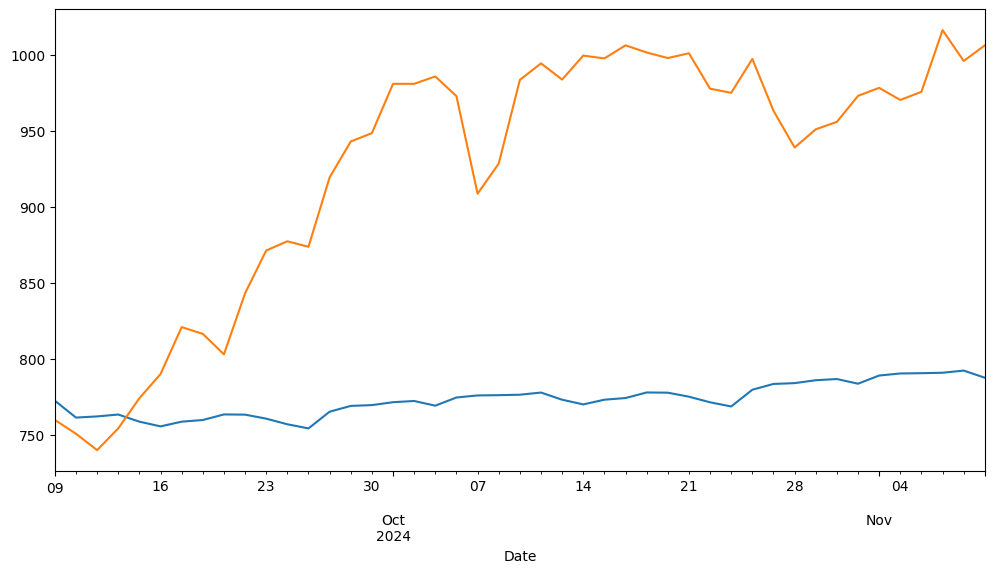

In [93]:
y_pred.plot(figsize=(12,6))
df_test['Close'].plot();

In [94]:
from sklearn.metrics import mean_squared_error

mean_squared_error(df_test['Close'], y_pred)

29333.02709888568

In [95]:
import math

math.sqrt(mean_squared_error(df_test['Close'], y_pred))

171.26887370122358